In [1]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, mutual_info_classif, RFE, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

# Methods

In [2]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame
    
def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame
    
def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = encode_variable(data_frame[target])
    return X, y 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def change_of_evaluation_variance_threshold(X,y,model,metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X: A pandas dataFrame with features
    :param y: A pandas dataFrame with labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    """
    lst = list(np.arange(0.0, 1.0, 0.1))
    score = []
    for k in lst:
        features = get_features_variance_threshold(X, threshold=k)
        
        X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.3, random_state=42)
        y_test = list(np.array(y_test.values).flatten())
        y_train = list(np.array(y_train.values).flatten())
        
#         print("Variance: {} - features: {}".format(k,features))

        model.fit(X_train, y_train)
        mean = cross_val_score(model, X_test, y_test, cv=10).mean()
        variance = cross_val_score(model, X_test, y_test, cv=10).var()
        score.append([k, mean, variance])
#     print(score)
    df = pd.DataFrame(score, columns=["variance", "mean", "std"])
    sns.pointplot(df["variance"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["variance"]].values[0][0]
    
def change_of_evaluation_univariate_feature_selection(X,y,model, metric="precision", linear=True):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X: A pandas dataFrame with features
    :param y: A pandas dataFrame with labels
    :param linear: If true > F-score if false > mutual information
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    score = []
    for k in range(len(X.columns),0,-1):
        df = show_kbest(data,"gender",linear_rel=linear, k=k)
        df = df[df["Support"] == True]
        columns = df["Attribute"].values
        X_ = X[columns]

        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)
        y_test = list(np.array(y_test.values).flatten())
        y_train = list(np.array(y_train.values).flatten())

        model.fit(X_train, y_train)
        mean = cross_val_score(model, X_test, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_test, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]
    
    
def under_sample(X,y):
    """ Returns resampled features and labels
    :param X: Features data frame
    :param y: Label data frame
    :return X_resampled, y_resampled: Numpy features array and corresponding lable array
    """
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X, y)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def generate_classification_report(X,y, model):
    """ Prints classification report
    :param X: Features data frame
    :param y: Label data frame
    :param model: Sklearn model object
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_test = list(np.array(y_test).flatten())
    y_train = list(np.array(y_train).flatten())
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    target_names = ['female', 'male']
    mean = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").mean()
    var = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").var()
#     print("Cross Validated Accuracy: mean - {}, var - {}".format(mean, var))
    print("Accuracy Score: ", accuracy_score(y_test, pred))
    print("\nConfusion Matrix:\n")
    print(confusion_matrix(y_test, pred))
    print("\nClassification Report:\n")
    print(classification_report(y_test, pred, target_names=target_names))
    
def full_report(X,y,base, model):
    """ Prints classification report for model over different feature selection models
    :param X: features dataframe
    :param y: labels dataframe
    :param model: Sklearn object
    """
    print("""Feature Selection: F-SCORE: \n""")
    print("""###############################################################""")
    k = change_of_evaluation_univariate_feature_selection(X_resampled,y_resampled,
                                                              model, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=True)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_resampled[features],
                                       y_resampled, r_forest)
    print("""Feature Selection: MUTUAL INFORMATION: \n""")
    print("""###############################################################""")
    k = change_of_evaluation_univariate_feature_selection(X_resampled,y_resampled,
                                                              model,linear=False, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=False)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_resampled[features],
                                       y_resampled, r_forest)
    print("""Feature Selection: Variance Threshold: \n""")
    print("""###############################################################""")
    v = change_of_evaluation_variance_threshold(X_resampled,y_resampled,model, metric="accuracy")
#     print(v)
    features = get_features_variance_threshold(base,threshold=v)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_resampled[features],
                                   y_resampled, r_forest)

# Load the data

In [3]:
data = pd.read_pickle("../data/final_sets/countries/model/2016_german")

In [4]:
data.head()

,gender,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,is_alive,distance_birth,distance_death,distance_delta,nationality_num,party_num,occupation_num,year_interval
7,male,2011,1.000,2.021104e-19,0,1,1,1652.0,70,no,142,71,71,1,0,1,3
113,male,2012,0.920,2.530002e-05,2,5,3,2376.0,73,no,128,54,74,1,0,1,3
127,male,2009,0.625,-1.456437e-19,0,4,4,32143.0,60,no,113,53,60,1,0,2,2
132,male,2009,1.000,9.096369e-08,1,2,1,2268.0,71,no,103,31,72,1,0,1,2
158,male,2011,0.750,7.461692e-04,2,4,2,19536.0,48,no,165,117,48,1,0,1,3


In [5]:
data.shape

(1325, 17)

In [6]:
data.gender.value_counts()

male      1136
female     171
Name: gender, dtype: int64

# Preprocesing

In [7]:
data = preprocess_data_frame(data, ["gender"])
# data["gender"]

['female', 'male']
{0, 1}


In [8]:
X,y=split_dataframe(data,"gender")

[0, 1]
{0, 1}


In [9]:
X.head()

,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,distance_birth,distance_death,distance_delta,nationality_num,party_num,occupation_num,is_alive_no,is_alive_unknown,is_alive_yes,year_interval_1,year_interval_2,year_interval_3
0,2011,1.000,2.021104e-19,0,1,1,1652.0,70,142,71,71,1,0,1,1,0,0,0,0,1
1,2012,0.920,2.530002e-05,2,5,3,2376.0,73,128,54,74,1,0,1,1,0,0,0,0,1
2,2009,0.625,-1.456437e-19,0,4,4,32143.0,60,113,53,60,1,0,2,1,0,0,0,1,0
3,2009,1.000,9.096369e-08,1,2,1,2268.0,71,103,31,72,1,0,1,1,0,0,0,1,0
4,2011,0.750,7.461692e-04,2,4,2,19536.0,48,165,117,48,1,0,1,1,0,0,0,0,1


In [10]:
y.head()

,gender
0,1
1,1
2,1
3,1
4,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_test = list(np.array(y_test.values).flatten())
y_train = list(np.array(y_train.values).flatten())

# No feature selection

In [12]:
model = tree.DecisionTreeClassifier()

In [13]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [14]:
p = model.predict(X_test, y_test)

In [15]:
accuracy_score(y_test, p)

0.7735368956743003

In [16]:
scores = cross_val_score(model, X_test, y_test, cv=10)
scores.var()

0.00349327012788637

In [17]:
def plot_loged(data, col_name):
    x= np.log(data[col_name])
    x = x[~np.isnan(x)]
    x = x[x != np.inf]
    x = x[x != -np.inf]
    sns.distplot(x)

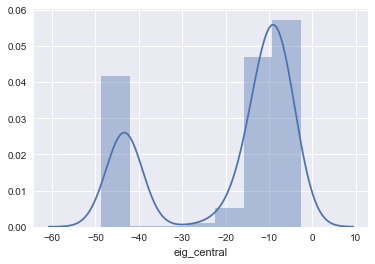

In [18]:
plot_loged(data, "eig_central")

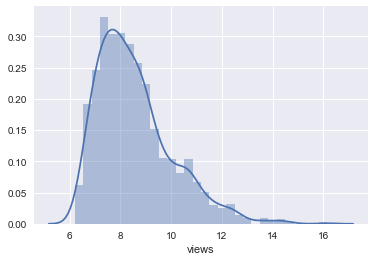

In [19]:
plot_loged(data, "views")

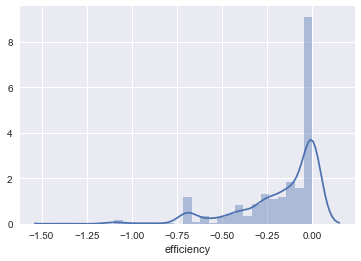

In [20]:
plot_loged(data, "efficiency")

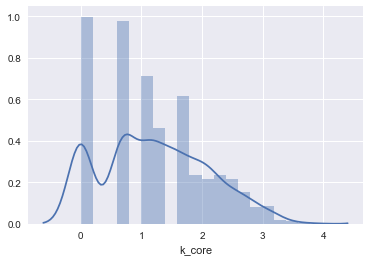

In [21]:
plot_loged(data, "k_core")

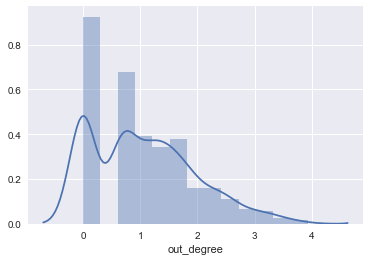

In [22]:
plot_loged(data, "out_degree")

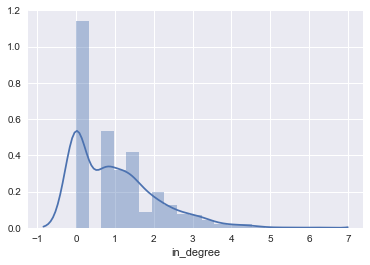

In [23]:
plot_loged(data, "in_degree")

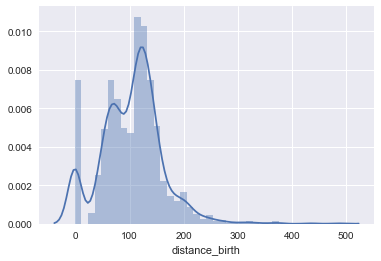

In [24]:
sns.distplot(data["distance_birth"])

# Algorithm Comparison

In [25]:
# SVM
s_vm = svm.SVC()
# Logistic regression
log_reg = LogisticRegression()
# Decision Tree
d_tree = tree.DecisionTreeClassifier()
# Random Forest
r_forest = RandomForestClassifier()

# Undersampling

In [26]:
X_resampled, y_resampled = under_sample(X,y)
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.DataFrame(y_resampled, columns=["gender"])
base = df_concat = pd.concat([X_resampled, y_resampled], axis=1)
# base.head()

[(0, 171), (1, 171)]


# SVM

Feature Selection: F-SCORE: 

###############################################################


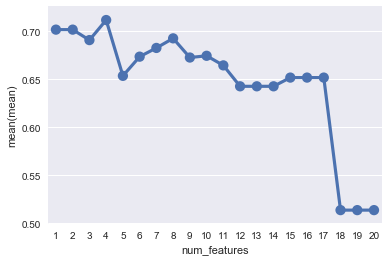

Number of features:  4
Features:  ['distance_birth' 'distance_death' 'is_alive_no' 'is_alive_yes']
Accuracy Score:  0.6811594202898551

Confusion Matrix:

[[26 11]
 [11 21]]

Classification Report:

             precision    recall  f1-score   support

     female       0.70      0.70      0.70        37
       male       0.66      0.66      0.66        32

avg / total       0.68      0.68      0.68        69

Feature Selection: MUTUAL INFORMATION: 

###############################################################


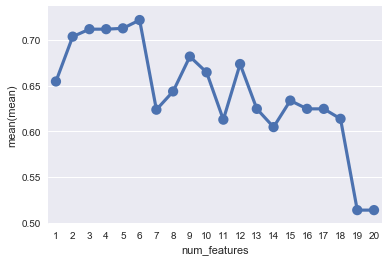

Number of features:  6
Features:  ['distance_birth' 'distance_death' 'is_alive_no' 'is_alive_unknown'
 'is_alive_yes' 'year_interval_1']
Accuracy Score:  0.6811594202898551

Confusion Matrix:

[[26 11]
 [11 21]]

Classification Report:

             precision    recall  f1-score   support

     female       0.70      0.70      0.70        37
       male       0.66      0.66      0.66        32

avg / total       0.68      0.68      0.68        69

Feature Selection: Variance Threshold: 

###############################################################


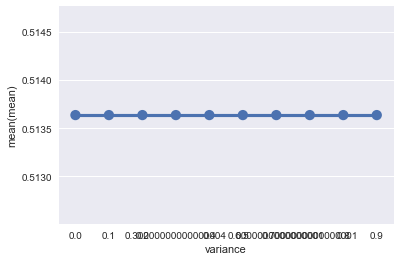

Number of features:  20
Features:  Index(['entered', 'efficiency', 'eig_central', 'in_degree', 'k_core',
       'out_degree', 'views', 'age', 'distance_birth', 'distance_death',
       'distance_delta', 'nationality_num', 'party_num', 'occupation_num',
       'is_alive_no', 'is_alive_unknown', 'is_alive_yes', 'year_interval_1',
       'year_interval_2', 'year_interval_3'],
      dtype='object')
Accuracy Score:  0.6666666666666666

Confusion Matrix:

[[26 11]
 [12 20]]

Classification Report:

             precision    recall  f1-score   support

     female       0.68      0.70      0.69        37
       male       0.65      0.62      0.63        32

avg / total       0.67      0.67      0.67        69



In [27]:
full_report(X_resampled, y_resampled, base, s_vm)

# Logistic Regression

Feature Selection: F-SCORE: 

###############################################################


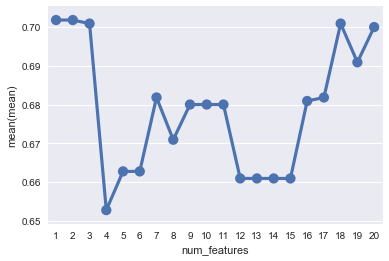

Number of features:  1
Features:  ['is_alive_yes']
Accuracy Score:  0.7101449275362319

Confusion Matrix:

[[25 12]
 [ 8 24]]

Classification Report:

             precision    recall  f1-score   support

     female       0.76      0.68      0.71        37
       male       0.67      0.75      0.71        32

avg / total       0.72      0.71      0.71        69

Feature Selection: MUTUAL INFORMATION: 

###############################################################


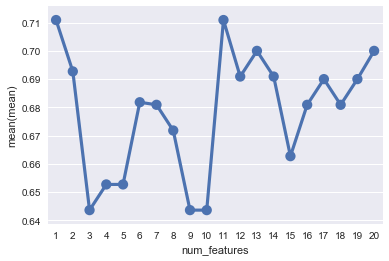

Number of features:  1
Features:  ['distance_death']
Accuracy Score:  0.6231884057971014

Confusion Matrix:

[[32  5]
 [21 11]]

Classification Report:

             precision    recall  f1-score   support

     female       0.60      0.86      0.71        37
       male       0.69      0.34      0.46        32

avg / total       0.64      0.62      0.59        69

Feature Selection: Variance Threshold: 

###############################################################


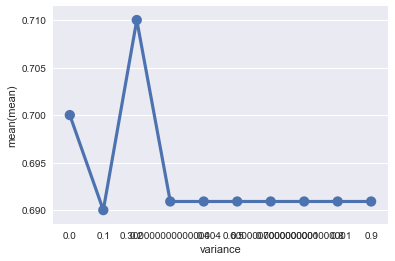

Number of features:  15
Features:  Index(['entered', 'in_degree', 'k_core', 'out_degree', 'views', 'age',
       'distance_birth', 'distance_death', 'distance_delta', 'party_num',
       'occupation_num', 'is_alive_no', 'is_alive_yes', 'year_interval_2',
       'year_interval_3'],
      dtype='object')
Accuracy Score:  0.6521739130434783

Confusion Matrix:

[[27 10]
 [14 18]]

Classification Report:

             precision    recall  f1-score   support

     female       0.66      0.73      0.69        37
       male       0.64      0.56      0.60        32

avg / total       0.65      0.65      0.65        69



In [28]:
full_report(X_resampled, y_resampled, base, log_reg)

# Decision Tree 

Feature Selection: F-SCORE: 

###############################################################


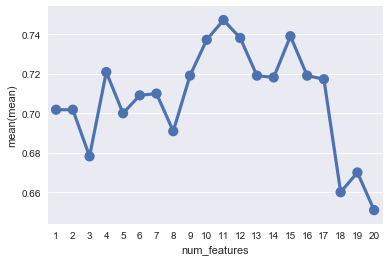

Number of features:  11
Features:  ['entered' 'efficiency' 'distance_birth' 'distance_death' 'distance_delta'
 'nationality_num' 'party_num' 'is_alive_no' 'is_alive_unknown'
 'is_alive_yes' 'year_interval_1']
Accuracy Score:  0.6521739130434783

Confusion Matrix:

[[27 10]
 [14 18]]

Classification Report:

             precision    recall  f1-score   support

     female       0.66      0.73      0.69        37
       male       0.64      0.56      0.60        32

avg / total       0.65      0.65      0.65        69

Feature Selection: MUTUAL INFORMATION: 

###############################################################


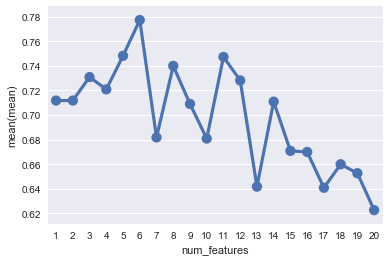

Number of features:  6
Features:  ['eig_central' 'distance_birth' 'distance_death' 'party_num' 'is_alive_no'
 'is_alive_yes']
Accuracy Score:  0.5942028985507246

Confusion Matrix:

[[22 15]
 [13 19]]

Classification Report:

             precision    recall  f1-score   support

     female       0.63      0.59      0.61        37
       male       0.56      0.59      0.58        32

avg / total       0.60      0.59      0.59        69

Feature Selection: Variance Threshold: 

###############################################################


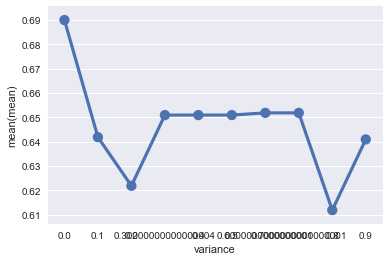

Number of features:  20
Features:  Index(['entered', 'efficiency', 'eig_central', 'in_degree', 'k_core',
       'out_degree', 'views', 'age', 'distance_birth', 'distance_death',
       'distance_delta', 'nationality_num', 'party_num', 'occupation_num',
       'is_alive_no', 'is_alive_unknown', 'is_alive_yes', 'year_interval_1',
       'year_interval_2', 'year_interval_3'],
      dtype='object')
Accuracy Score:  0.6376811594202898

Confusion Matrix:

[[26 11]
 [14 18]]

Classification Report:

             precision    recall  f1-score   support

     female       0.65      0.70      0.68        37
       male       0.62      0.56      0.59        32

avg / total       0.64      0.64      0.64        69



In [29]:
full_report(X_resampled, y_resampled, base, d_tree)

# Random Forest

Feature Selection: F-SCORE: 

###############################################################


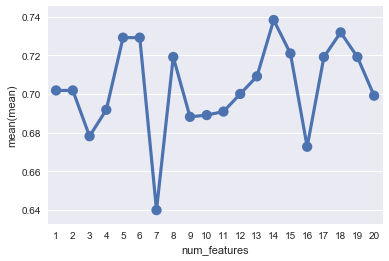

Number of features:  14
Features:  ['entered' 'efficiency' 'views' 'distance_birth' 'distance_death'
 'distance_delta' 'nationality_num' 'party_num' 'is_alive_no'
 'is_alive_unknown' 'is_alive_yes' 'year_interval_1' 'year_interval_2'
 'year_interval_3']
Accuracy Score:  0.6811594202898551

Confusion Matrix:

[[28  9]
 [13 19]]

Classification Report:

             precision    recall  f1-score   support

     female       0.68      0.76      0.72        37
       male       0.68      0.59      0.63        32

avg / total       0.68      0.68      0.68        69

Feature Selection: MUTUAL INFORMATION: 

###############################################################


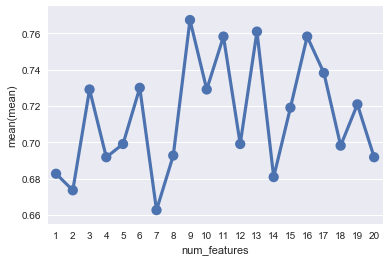

Number of features:  9
Features:  ['entered' 'eig_central' 'in_degree' 'distance_birth' 'distance_death'
 'party_num' 'is_alive_no' 'is_alive_unknown' 'is_alive_yes']
Accuracy Score:  0.7536231884057971

Confusion Matrix:

[[28  9]
 [ 8 24]]

Classification Report:

             precision    recall  f1-score   support

     female       0.78      0.76      0.77        37
       male       0.73      0.75      0.74        32

avg / total       0.75      0.75      0.75        69

Feature Selection: Variance Threshold: 

###############################################################


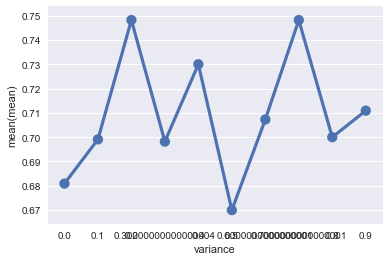

Number of features:  15
Features:  Index(['entered', 'in_degree', 'k_core', 'out_degree', 'views', 'age',
       'distance_birth', 'distance_death', 'distance_delta', 'party_num',
       'occupation_num', 'is_alive_no', 'is_alive_yes', 'year_interval_2',
       'year_interval_3'],
      dtype='object')
Accuracy Score:  0.6956521739130435

Confusion Matrix:

[[28  9]
 [12 20]]

Classification Report:

             precision    recall  f1-score   support

     female       0.70      0.76      0.73        37
       male       0.69      0.62      0.66        32

avg / total       0.70      0.70      0.69        69



In [31]:
full_report(X_resampled, y_resampled, base, r_forest)

In [32]:
# TODO: 
# 1. RFE
# 2. Figure out most accurate model
# 3. List out most important features
# 4. Do the same for loged skewed values